# 6장. 임베딩을 사용한 감성 프로그래밍

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch06/06-sentiment-analysis.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch06/06-sentiment-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05

## 1. 단어의 의미 구축하기
### 1-1. 간단한 방법: 양수와 음수
숫자에서 의미를 유도하는 방식 - 양수와 음수 인코딩   
빈정거리는(sarcasm) 헤드라인의 단어에는 +1   
평범한 헤드라인의 단어에는 -1   
-> 그 결과로 **딕셔너리 형태의 단어별 점수 인코딩 사전**을 얻을 수 있다.   
-> 새로운 문장을 해석할 때 각 단어의 점수를 더해서, 양수라면 빈정거리는 문장 / 음수라면 평범한 문장으로 판단할 수 있다.

### 1-2. 조금 더 어려운 방법: 벡터
멘탈 모델: 다른 단어와의 연관성을 부여하여 상대적인 의미를 만든다.    
한 단어의 벡터와 다른 단어의 벡터 사이에 있는 관계와 축을 기반으로 하는 상대적인 의미를 도출한다.   
--> 임베딩: 신경망을 훈련하여 학습된 단어의 벡터 표현

## 2. 텐서플로의 임베딩
### 2-0(준비). Sarcasm 데이터셋 로딩 및 전처리

In [1]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [2]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [72]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

c:\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [73]:
# ▼ 훈련 세트와 테스트 세트, 훈련 라벨과 테스트 라벨 분리하기
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
# ▼ 단어 단위로 토큰화
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

# ▼ 훈련 세트와 테스트 세트를 시퀀스 리스트로 만들고, 패딩 적용
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### 2-1. 임베딩을 사용해 빈정거림 감지기 만들기

In [7]:
import numpy as np

# np.arrapy로 변환해주기
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [12]:
display(training_padded.shape, training_labels.shape)

(23000, 100)

(23000,)

임베딩 층을 만들 때, **어휘사전 크기**와 **임베딩 차원**을 먼저 지정해야 한다.   
embedding_dim을 16으로 지정했다면, 어휘사전에 있는 각 단어는 16차원 벡터에 할당된다.   
훈련 데이터의 입력과 레이블을 매핑하기 위해 신경망이 훈련될 때 **역전파**를 통해 벡터가 학습된다. cf) RNN   
<br>
풀링의 경우, 평균풀링을 이용한다(GlobalAveragePolling1D)   

In [8]:
# vocab_size = 10000
# embedding_dim = 16

# ▼ 모델 생성하기
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


임베딩층 - 훈련 가능한 파라미터 수 160000개 = 어휘사전 크기 10000 x 벡터 16차원   
풀링층 - 단순히 평균하여 16차원 벡터를 만들기 때문에 훈련가능한 파라미터는 0   
밀집층 - (가중치 24 x 16차원) + (절편 16) = 408개 파라미터 학습   
마지막층 - (1 x 24) + 1 = 25개 파라미터

In [13]:
# ▼ 모델 훈련시키기
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 3s 3ms/step - loss: 0.6816 - accuracy: 0.5601 - val_loss: 0.6605 - val_accuracy: 0.5840
Epoch 2/30
719/719 [==============================] - 2s 2ms/step - loss: 0.5564 - accuracy: 0.7229 - val_loss: 0.4830 - val_accuracy: 0.7838
Epoch 3/30
719/719 [==============================] - 2s 3ms/step - loss: 0.3978 - accuracy: 0.8294 - val_loss: 0.4496 - val_accuracy: 0.7873
Epoch 4/30
719/719 [==============================] - 2s 2ms/step - loss: 0.3289 - accuracy: 0.8617 - val_loss: 0.4215 - val_accuracy: 0.8072
Epoch 5/30
719/719 [==============================] - 2s 2ms/step - loss: 0.2908 - accuracy: 0.8793 - val_loss: 0.4261 - val_accuracy: 0.8088
Epoch 6/30
719/719 [==============================] - 2s 2ms/step - loss: 0.2627 - accuracy: 0.8929 - val_loss: 0.4365 - val_accuracy: 0.8053
Epoch 7/30
719/719 [==============================] - 2s 2ms/step - loss: 0.2415 - accuracy: 0.9026 - val_loss: 0.4480 - val_accuracy: 0.8032
Epoch 

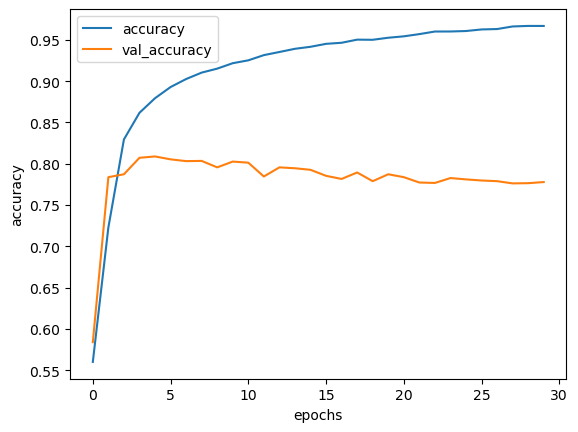

In [14]:
import matplotlib.pyplot as plt

# ▼ 정확도 시각화
plt.plot(history.history['accuracy'])       # 훈련세트
plt.plot(history.history['val_accuracy'])   # 검증세트
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

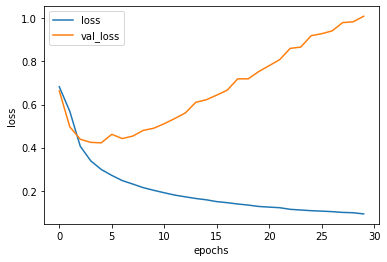

In [13]:
# ▼ 손실값 시각화
plt.plot(history.history['loss'])       # 훈련세트
plt.plot(history.history['val_loss'])   # 검증세트
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

과대적합이 나타난 것을 확인할 수 있다.

### 2-2. 언어 모델의 과대적합 줄이기

#### 2-2-1. 학습률 조정하기
과대적합을 일으키는 가장 큰 요소: 옵티마이저의 학습률(learning rate)이 너무 높은 경우 = 신경망이 너무 빠르게 학습한다   
learning_rate의 기본값은 0.001 -> 0.0001로 변경   
beta_1과 beta_2(0~1사이, 둘 다 1에 가까운 값 사용), amsgrad는 기본값 그대로 사용   

<과대적합 해결방향>
1. 학습률 낮추기
2. 에포크 늘리기
3. 드롭아웃 추가

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, 
                               beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

# 낮은 학습률이 신경망에 큰 영향을 미치므로, 100번으로 늘려본다.
history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6878 - accuracy: 0.5596 - val_loss: 0.6837 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6852 - accuracy: 0.5596 - val_loss: 0.6823 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6843 - accuracy: 0.5596 - val_loss: 0.6813 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6830 - accuracy: 0.5596 - val_loss: 0.6800 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6812 - accuracy: 0.5596 - val_loss: 0.6779 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6786 - accuracy: 0.5596 - val_loss: 0.6754 - val_accuracy: 0.5700
Epoch 7/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6750 - accuracy: 0.5597 - val_loss: 0.6713 - val_accuracy: 0.5700

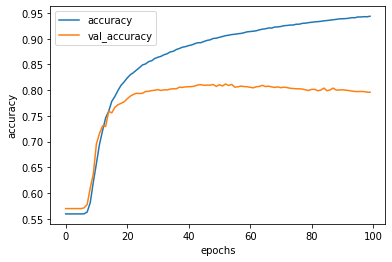

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

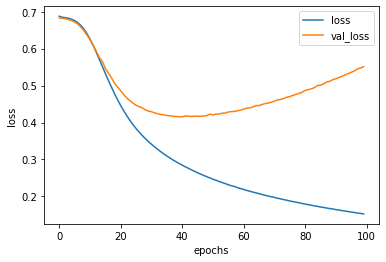

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

더 오래 걸리지만 손실은 낮아짐 loss: 0.1491 - accuracy: 0.9448   
기본 Adam 옵티마이저 사용했으나, 이후 변경해보자.

#### 2-2-2. 어휘 사전 크기 바꾸기

단어의 빈도 확인: tokenizer.word_counts

In [20]:
# ▼ orderedDict - 단어별 빈도 확인할 수 있는 딕셔너리
wc=tokenizer.word_counts
print(list(wc.items())[:6])

[('former', 90), ('versace', 1), ('store', 44), ('clerk', 9), ('sues', 13), ('secret', 78)]


In [21]:
from collections import OrderedDict

# ▼ 카운트가 높은 순으로 정렬
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))

print(list(newlist.items())[:6])

[('new', 1318), ('trump', 1117), ('man', 1075), ('not', 634), ('just', 501), ('will', 484)]


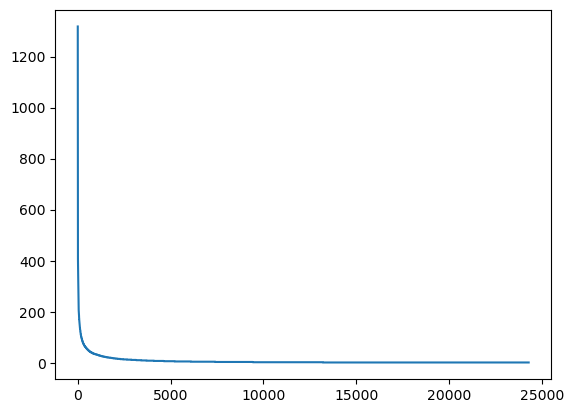

In [22]:
xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])

plt.plot(xs,ys)
plt.show()

많이 사용되는 단어는 소수이고, 대부분의 단어는 매우 적게 사용되지만, 중요도는 모두 동일하다.    
즉, 검증세트보다 큰 훈련세트를 사용한다면 훈련 세트에 있는 단어가 검증 세트에는 없는 경우가 많을 것.

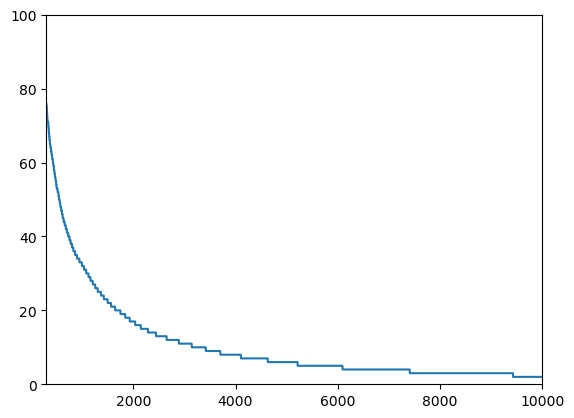

In [23]:
plt.plot(xs,ys)
plt.axis([300,10000,0,100])     # x축을 300~10000, y축을 0~100으로 범위 조정
plt.show()                      # 확인

말뭉치에 20000개 이상의 단어를 10000개만 사용해 훈련하였는데,   
위 그래프를 보면 2000~10000 사이에 있는 단어도 20번 이하로 사용된다.   
따라서 어휘사전 크기를 2000으로 바꿔보자.

In [24]:
vocab_size = 2000

In [25]:
# ▼ 새로 지정한 사이즈를 기준으로 tokenizer 다시 저장, 단어 개수 다시 계산(fit_on_texts)
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

# ▼ 훈련세트와 테스트세트를 시퀀스로 변경하고 패딩 적용
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [26]:
# ▼ 시퀀스 리스트를 np.array로
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [27]:
# ▼ 모델 재생성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [29]:
# ▼ 에포크를 30으로 훈련 시작
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3882 - accuracy: 0.8132 - val_loss: 0.4879 - val_accuracy: 0.7730
Epoch 2/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3893 - accuracy: 0.8156 - val_loss: 0.4824 - val_accuracy: 0.7703
Epoch 3/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3887 - accuracy: 0.8149 - val_loss: 0.4798 - val_accuracy: 0.7697
Epoch 4/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3879 - accuracy: 0.8166 - val_loss: 0.4808 - val_accuracy: 0.7692
Epoch 5/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3882 - accuracy: 0.8149 - val_loss: 0.4875 - val_accuracy: 0.7644
Epoch 6/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3880 - accuracy: 0.8143 - val_loss: 0.4810 - val_accuracy: 0.7684
Epoch 7/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3868 - accuracy: 0.8156 - val_loss: 0.4924 - val_accuracy: 0.7603
Epoch 

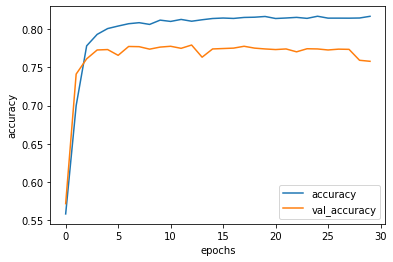

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

▲ 정확도는 많이 줄어든 것이 보인다.   
그러나 훈련 세트 정확도와 검증 세트 정확도가 가까워진 것을 보아 과대적합이 해결되었다.   

▼ 검증 세트 손실이 증가하기는 하지만, 이전보다 느리게 증가한다.

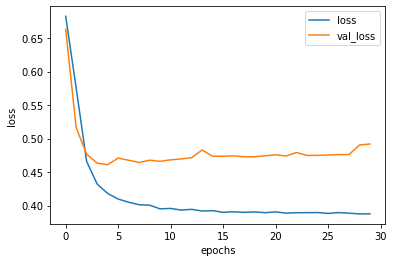

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 2-2-3. 임베딩 차원 바꾸기

이전에는 임베딩 차원을 16으로 지정했다.   
하지만 어휘 사전이 줄어들면서 벡터의 일부 원소가 비거나 작은 값이 될 수 있다.   
* 임베딩 크기를 결정할 때, 어휘 사전의 네제곱근을 사용하는 것이 좋다.
* 2000의 네제곱근은 6.687   ->      임베딩 차원을 7로

In [30]:
embedding_dim = 7

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [32]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6845 - accuracy: 0.5577 - val_loss: 0.6769 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6220 - accuracy: 0.6459 - val_loss: 0.5542 - val_accuracy: 0.7247
Epoch 3/100
719/719 [==============================] - 1s 1ms/step - loss: 0.5001 - accuracy: 0.7590 - val_loss: 0.4930 - val_accuracy: 0.7530
Epoch 4/100
719/719 [==============================] - 1s 1ms/step - loss: 0.4504 - accuracy: 0.7828 - val_loss: 0.4735 - val_accuracy: 0.7641
Epoch 5/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4288 - accuracy: 0.7941 - val_loss: 0.4776 - val_accuracy: 0.7584
Epoch 6/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4184 - accuracy: 0.7992 - val_loss: 0.4635 - val_accuracy: 0.7706
Epoch 7/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4108 - accuracy: 0.8036 - val_loss: 0.4621 - val_accuracy: 0.7743

임베딩 차원을 줄여서 모델 훈련속도가 30% 이상 빨라졌다.   

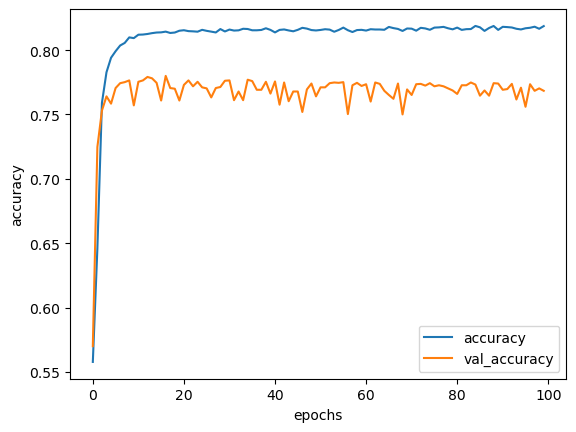

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

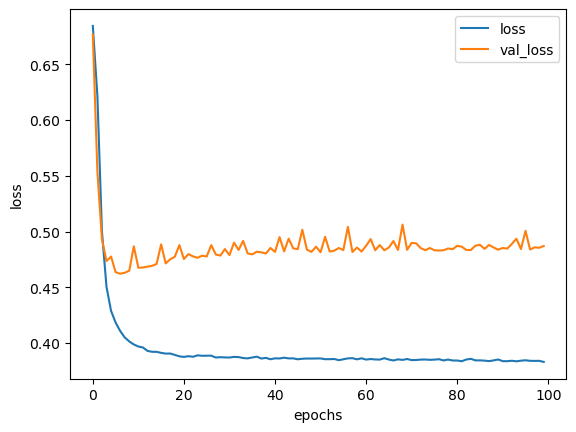

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

그래프 변동이 있기는 하지만, 시간이 갈수록 평평해진다.   
* 참고) 변동이 큰 경우도 나쁜 결과이다. 모델이 어느정도 수렴해야 한다.

#### 2-2-4. 모델 구조 변경하기

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),        # 밀집층의 뉴런을 8개로 줄이기
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [36]:
num_epochs = 100    # 100번 훈련
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6832 - accuracy: 0.5596 - val_loss: 0.6752 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 1ms/step - loss: 0.6555 - accuracy: 0.5903 - val_loss: 0.6239 - val_accuracy: 0.6544
Epoch 3/100
719/719 [==============================] - 1s 2ms/step - loss: 0.5706 - accuracy: 0.7173 - val_loss: 0.5394 - val_accuracy: 0.7374
Epoch 4/100
719/719 [==============================] - 1s 1ms/step - loss: 0.4910 - accuracy: 0.7713 - val_loss: 0.4907 - val_accuracy: 0.7576
Epoch 5/100
719/719 [==============================] - 1s 1ms/step - loss: 0.4499 - accuracy: 0.7883 - val_loss: 0.4870 - val_accuracy: 0.7549
Epoch 6/100
719/719 [==============================] - 1s 1ms/step - loss: 0.4307 - accuracy: 0.7943 - val_loss: 0.4680 - val_accuracy: 0.7679
Epoch 7/100
719/719 [==============================] - 1s 1ms/step - loss: 0.4179 - accuracy: 0.8025 - val_loss: 0.4648 - val_accuracy: 0.7765

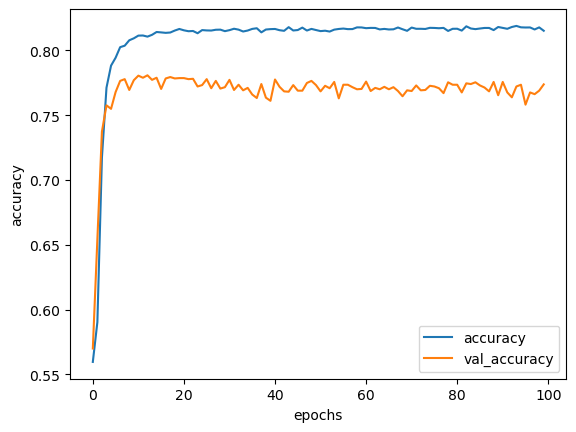

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

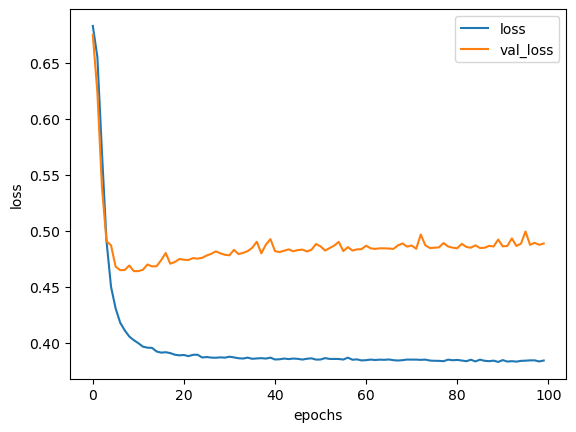

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

24개 뉴런을 사용한 결과와 비교해서 전체적인 결과는 비슷하지만, 그래프의 요동이 줄어들었다. + 훈련 속도도 조금 더 빨라졌다.   

#### 2-2-5. 드롭아웃 사용하기

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(.25),                   # 25% 드롭아웃
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [40]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6860 - accuracy: 0.5583 - val_loss: 0.6793 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6677 - accuracy: 0.5877 - val_loss: 0.6448 - val_accuracy: 0.6972
Epoch 3/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6041 - accuracy: 0.6865 - val_loss: 0.5608 - val_accuracy: 0.7374
Epoch 4/100
719/719 [==============================] - 1s 1ms/step - loss: 0.5386 - accuracy: 0.7329 - val_loss: 0.5102 - val_accuracy: 0.7579
Epoch 5/100
719/719 [==============================] - 1s 1ms/step - loss: 0.4979 - accuracy: 0.7633 - val_loss: 0.4903 - val_accuracy: 0.7584
Epoch 6/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4781 - accuracy: 0.7693 - val_loss: 0.4741 - val_accuracy: 0.7711
Epoch 7/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4642 - accuracy: 0.7768 - val_loss: 0.4703 - val_accuracy: 0.7687

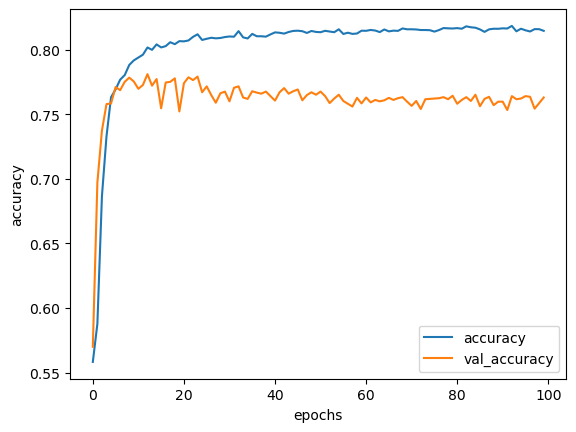

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

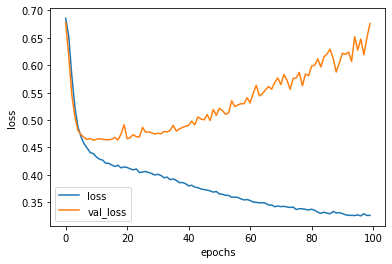

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

▲ 훈련 정확도가 올라가지만, 검증 정확도는 감소,   
검증 손실이 증가하는 패턴 ===> 과대적합이 다시 나타났다.   
* 적은 뉴런을 사용할 때 드롭아웃을 적용하는 것은 좋은 방법이 아니다.

#### 2-2-6. 규제 사용하기

L1 규제: 라쏘(Lasso) = 층의 가중치를 0 또는 0에 가까운 값으로 만듦   
L2 규제: 리지(ridge) = 가중치 제곱을 패널티로 사용, 0에서 먼 값과 0에 가까운 값으로 만든다.   
==> 이 두 방식을 모두 사용할 수 있고, 이를 일래스틱넷(elastic net) 규제라고 한다.

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.01)),     # regularization(규제) 사용: 가중치의 크기를 감소시켜 과대적합 방지
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [49]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.7099 - accuracy: 0.5596 - val_loss: 0.6846 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 1ms/step - loss: 0.6861 - accuracy: 0.5596 - val_loss: 0.6830 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 1s 1ms/step - loss: 0.6851 - accuracy: 0.5596 - val_loss: 0.6816 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 1s 1ms/step - loss: 0.6812 - accuracy: 0.5596 - val_loss: 0.6744 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 1s 1ms/step - loss: 0.6654 - accuracy: 0.5875 - val_loss: 0.6532 - val_accuracy: 0.6468
Epoch 6/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6370 - accuracy: 0.6639 - val_loss: 0.6259 - val_accuracy: 0.7032
Epoch 7/100
719/719 [==============================] - 1s 1ms/step - loss: 0.6054 - accuracy: 0.7141 - val_loss: 0.5983 - val_accuracy: 0.7147

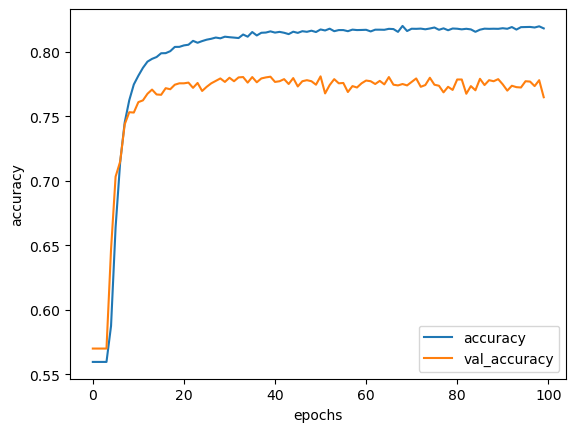

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

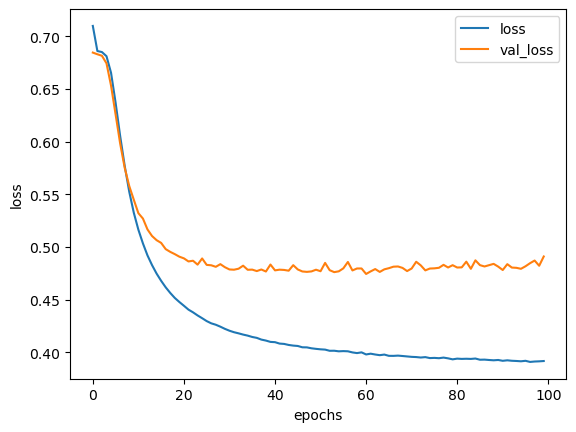

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 2-2-7. 다른 고려 사항

하이퍼파라미터를 조정하여 실험   
ex) 문장의 최대 길이 -> 문장 길이를 짧은 것에서 긴 것까지 정렬해서 문장 길이의 분포를 확인   
100개 이상을 가진 문장은 200개 미만이므로, 불필요한 패딩을 많이 추가하게 되어 모델 성능에 영향을 미친다.   
--> 최대 길이를 줄이자.

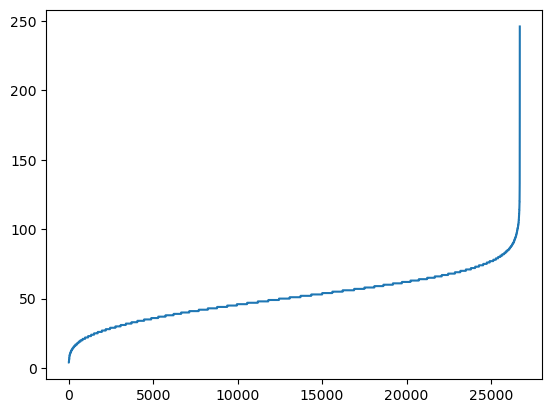

In [52]:
xs=[]
ys=[]
current_item=1
for item in sentences:
    xs.append(current_item)
    current_item=current_item+1
    ys.append(len(item))
newys = sorted(ys)

plt.plot(xs,newys)
plt.show()

### 2-3. 모델을 사용해 문장 분류하기

In [53]:
sentences = ["granny starting to fear spiders in the garden might be real", 
             "game of thrones season finale showing this sunday night", 
             "TensorFlow book will be a best seller"]

In [54]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[1, 803, 1, 753, 1, 1, 1, 1, 312, 1, 97], [123, 1, 1183, 160, 1, 1, 1, 1543, 152], [1, 235, 7, 1, 1, 47, 1]]


In [55]:
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
print(padded)

[[   1  803    1  753    1    1    1    1  312    1   97    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 123    1 1183  160    1    1    1 1543  152    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [56]:
print(model.predict(padded))
# 1번 문장: 아주 빈정대는 문장... 0.8
# 2번, 3번 문장: 빈정대는 문장일 가능성 낮음

1/1 [==============================] - 0s 93ms/step
[[0.80145353]
 [0.03175215]
 [0.21020332]]


## 3. 임베딩 시각화
임베딩 프로젝터(EmbeddingProjector)

In [58]:
# 참고) 딕셔너리 전환 방법 다시 확인해보자
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
reverse_word_index

{1: '<OOV>',
 2: 'new',
 3: 'trump',
 4: 'man',
 5: 'not',
 6: 'just',
 7: 'will',
 8: 'one',
 9: 'year',
 10: 'report',
 11: 'area',
 12: 'donald',
 13: 'day',
 14: 'u',
 15: 's',
 16: 'can',
 17: 'says',
 18: 'woman',
 19: 'first',
 20: 'time',
 21: 'like',
 22: 'no',
 23: 'get',
 24: 'old',
 25: 'trumps',
 26: 'off',
 27: 'now',
 28: 'life',
 29: 'obama',
 30: 'people',
 31: 'house',
 32: 'women',
 33: 'white',
 34: 'back',
 35: 'still',
 36: 'make',
 37: 'clinton',
 38: '5',
 39: 'world',
 40: 'americans',
 41: 'years',
 42: 'way',
 43: 'family',
 44: 'black',
 45: 'study',
 46: 'gop',
 47: 'best',
 48: 'bill',
 49: 'american',
 50: 'school',
 51: 'police',
 52: 'watch',
 53: '3',
 54: 'show',
 55: 'really',
 56: 'president',
 57: 'home',
 58: 'last',
 59: 'video',
 60: 'finds',
 61: 'death',
 62: 'cant',
 63: 'know',
 64: '10',
 65: 'things',
 66: 'good',
 67: 'going',
 68: 'state',
 69: 'hillary',
 70: 'love',
 71: 'nation',
 72: 'may',
 73: '2',
 74: 'health',
 75: 'say',
 76: '

In [57]:
# 임베딩 층의 가중치 추출 = weights
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)
# 단어가 2000개, 임베딩 층의 차원 7

(2000, 7)


In [59]:
print(tokenizer.index_word[2])  # new에 대한
print(weights[2])               # 7개 가중치

new
[-0.46272013  1.0526321   0.6191846  -0.8298898  -0.51828533  0.77045685
  0.51258606]


In [60]:
import io

# ▼ tab으로 구분된 파일(TSV(tav-seperated value)) 생성
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')  # 벡터를 저장하는 파일
out_m = io.open('meta.tsv', 'w', encoding='utf-8')  # 메타데이터를 저장하는 파일
for word_num in range(1, vocab_size):
    word = tokenizer.index_word[word_num]           # index : word 딕셔너리에서 해당 단어 뽑아옴 (word에 저장)
    embeddings = weights[word_num]                  # 그 단어이 index에 해당하는 가중치 (embeddings에 저장)
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n") # \t(탭)으로 구분
out_v.close()
out_m.close()
# 생성 완료

위에서 다운받은 tsv 파일을 https://projector.tensorflow.org/ 에서 임베딩 시각화를 할 수 있다.

## 4. 텐서플로 허브에서 사전 훈련된 임베딩 사용하기

사전 훈련된 임베딩 가져오기: 구글 뉴스에서 훈련된 Swivel 임베딩 - **문장 단위 인코딩**이다!

In [ ]:
# 파일 다시 불러오기: 이번에는 단어로 나누지 않고 문장을 그대로 쓸 거기 때문에 변수 다시 설정해야 한다.

with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [75]:
# 사이즈를 24000으로 조정해서 문장 세트를 다시 나누기

training_size = 24000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [64]:
import tensorflow_hub as hub

# 주의: 임베딩 정보만 담고있는 레이어이기 때문에, 은닉층과 출력층은 추가해야한다.
hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",        
    output_shape=[20], input_shape=[],                                  # input 사이즈는 미정
    dtype=tf.string, trainable=False                                    # 훈련 타입: 문자열, 이후에 추가로 훈련은 X
)

In [86]:
# ▼ hub_layer를 가지고 모델 생성
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),           # 은닉층 추가
    tf.keras.layers.Dense(1, activation='sigmoid')          # 출력층 추가
])

# 옵티마이저
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, 
                                beta_2=0.999, amsgrad=False)

# 컴파일
model.compile(loss='binary_crossentropy',optimizer=adam, 
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_18 (Dense)            (None, 16)                336       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [87]:
# model.fit에 넣을 때는 문장 리스트를 그대로 넣어준다. np.array여도 상관 없지만, 굳이 바꿀 필요는 없다.
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs,
                    validation_data=(testing_sentences, testing_labels))

Epoch 1/50
750/750 [==============================] - 2s 2ms/step - loss: 0.7258 - accuracy: 0.5004 - val_loss: 0.7022 - val_accuracy: 0.5293
Epoch 2/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6950 - accuracy: 0.5475 - val_loss: 0.6832 - val_accuracy: 0.5688
Epoch 3/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6795 - accuracy: 0.5758 - val_loss: 0.6724 - val_accuracy: 0.6006
Epoch 4/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6694 - accuracy: 0.5938 - val_loss: 0.6648 - val_accuracy: 0.6117
Epoch 5/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6620 - accuracy: 0.6053 - val_loss: 0.6590 - val_accuracy: 0.6312
Epoch 6/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6561 - accuracy: 0.6173 - val_loss: 0.6544 - val_accuracy: 0.6342
Epoch 7/50
750/750 [==============================] - 1s 1ms/step - loss: 0.6513 - accuracy: 0.6272 - val_loss: 0.6506 - val_accuracy: 0.6346
Epoch 

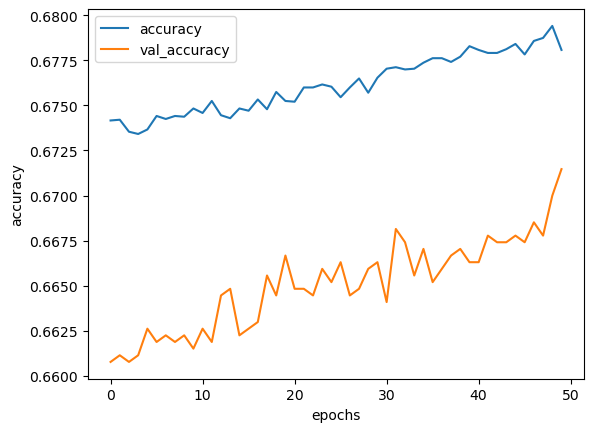

In [85]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

최고 정확도에 빠르게 도달하며, 과대적합이 크게 일어나지 않는다.    
50 에폭까지는 훈련과 검증 정확도의 값이 매우 가깝다.

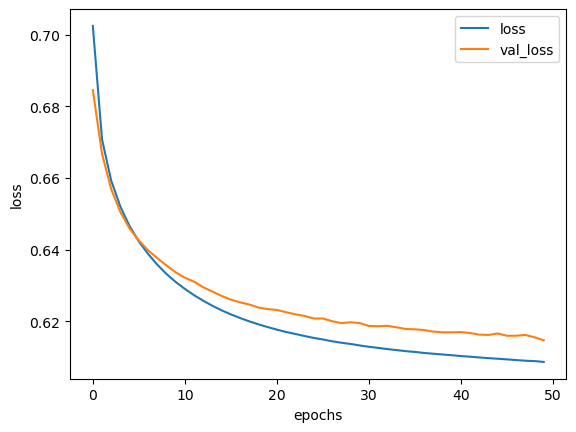

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

손실값도 매우 근접한 것을 확인할 수 있다.
<br><br>
하지만, 전반적으로 정확도가 67% 정도로 낮다.   
사전 훈련된 임베딩을 사용하면 훈련이 빠르고 과대적합이 적지만, 상황에 따라 최선이 아닐 수 있다.